##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 时间序列预测

<table class="tfo-notebook-buttons" align="left">
  <td> <img src="https://tensorflow.google.cn/images/tf_logo_32px.png"><a target="_blank" href="https://tensorflow.google.cn/tutorials/structured_data/time_series">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/time_series.ipynb"><img src="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/time_series.ipynb">在 Google Colab 中运行</a></td>
  <td> <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png"><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/structured_data/time_series.ipynb">在 GitHub 上查看源代码</a> </td>
  <td> <img src="https://tensorflow.google.cn/images/download_logo_32px.png"><a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb">下载笔记本</a> </td>
</table>

本教程是使用 TensorFlow 进行时间序列预测的简介。它构建了几种不同样式的模型，包括卷积神经网络 (CNN) 和循环神经网络 (RNN)。

本教程包括两个主要部分，每个部分包含若干小节：

- 预测单个时间步骤：
    - 单个特征。
    - 所有特征。
- 预测多个时间步骤：
    - 单次：一次做出所有预测。
    - 自回归：一次做出一个预测，并将输出馈送回模型。

## 安装

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [59]:
tf.__version__

'2.17.0'

## 天气数据集

本教程使用由<a href="https://www.bgc-jena.mpg.de/wetter/" class="external">马克斯·普朗克生物地球化学研究所</a>记录的<a href="https://www.bgc-jena.mpg.de" class="external">[天气时间序列数据集</a>。

此数据集包含了 14 个不同特征，例如气温、气压和湿度。自 2003 年起，这些数据每 10 分钟就会被收集一次。为了提高效率，您将仅使用 2009 至 2016 年之间收集的数据。数据集的这一部分由 François Chollet 为他的 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) 一书所准备。

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


本教程仅处理**每小时预测**，因此先从 10 分钟间隔到 1 小时对数据进行下采样：

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

让我们看一下数据。下面是前几行：

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


下面是一些特征随时间的演变：

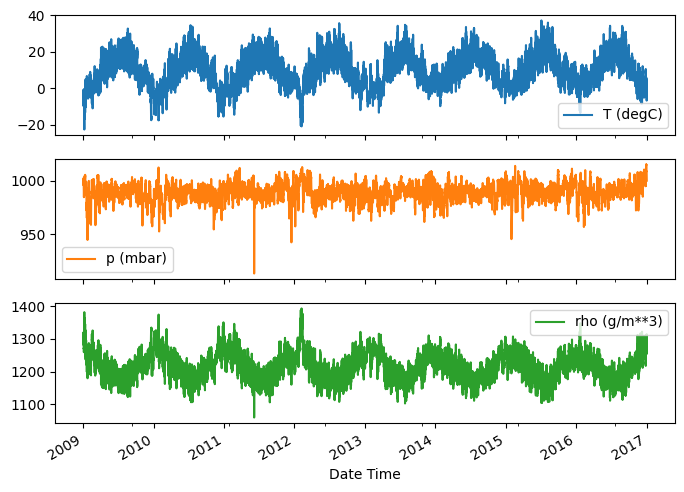

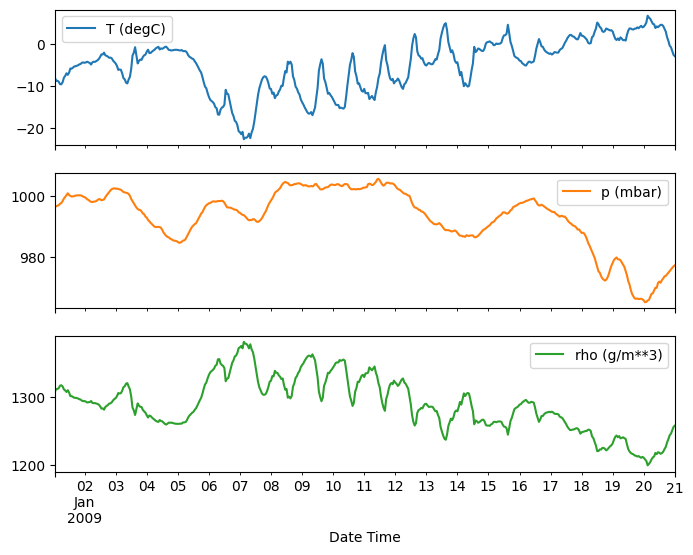

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 检查和清理

接下来，看一下数据集的统计数据：

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### 风速

值得注意的一件事是风速 (`wv (m/s)`) 的 `min` 值和最大值 (`max. wv (m/s)`) 列。这个 `-9999` 可能是错误的。

有一个单独的风向列，因此速度应大于零 (`>=0`)。将其替换为零：

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [9]:
bad_wv

,wv (m/s)
5,False
11,False
17,False
23,False
29,False
...,...
420521,False
420527,False
420533,False
420539,False


### 特征工程

在潜心构建模型之前，务必了解数据并确保传递格式正确的数据。

#### 风

数据的最后一列 `wd (deg)` 以度为单位给出了风向。角度不是很好的模型输入：360° 和 0° 应该会彼此接近，并平滑换行。如果不吹风，方向则无关紧要。

现在，风数据的分布状况如下：

Text(0, 0.5, 'Wind Velocity [m/s]')

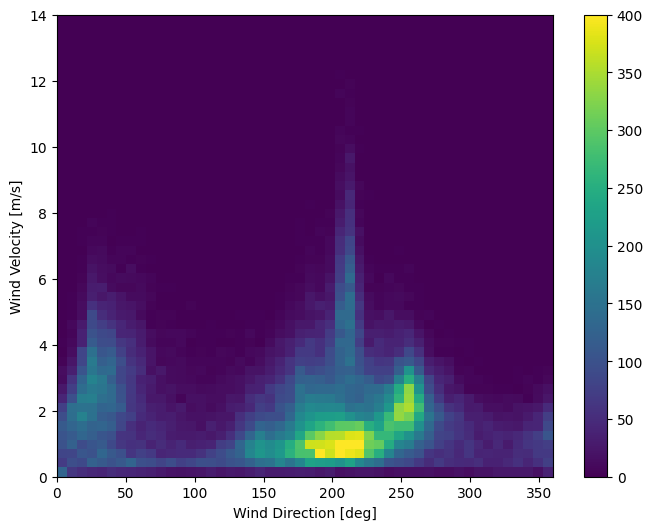

In [10]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

但是，如果将风向和风速列转换为风**向量**，模型将更容易解释：

In [11]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

模型正确解释风向量的分布要简单得多：

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

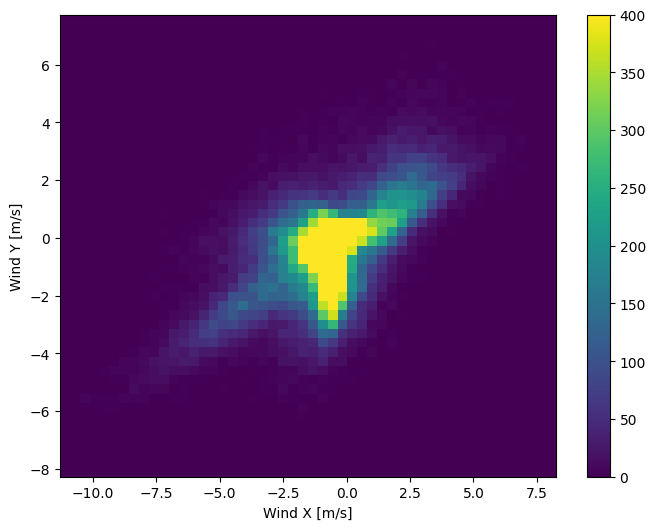

In [12]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 时间

同样，`Date Time` 列非常有用，但不是以这种字符串形式。首先将其转换为秒：

In [13]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

与风向类似，以秒为单位的时间不是有用的模型输入。作为天气数据，它有清晰的每日和每年周期性。可以通过多种方式处理周期性。

您可以通过使用正弦和余弦变换为清晰的“一天中的时间”和“一年中的时间”信号来获得可用的信号：

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

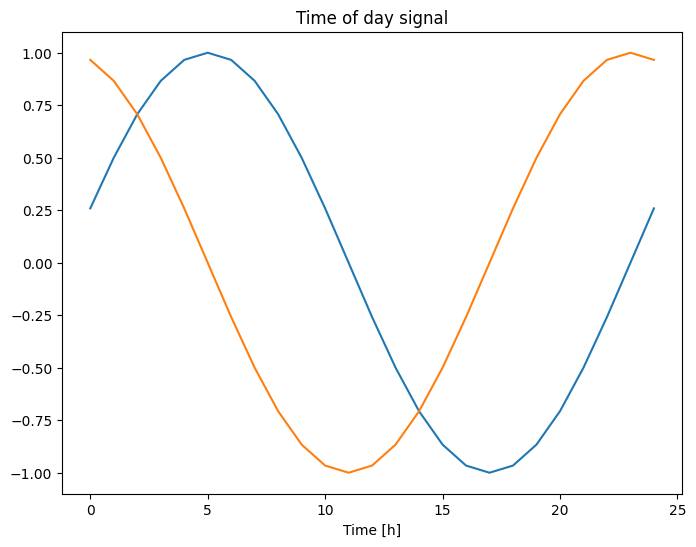

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

这使模型能够访问最重要的频率特征。在这种情况下，您提前知道了哪些频率很重要。

如果您没有该信息，则可以通过使用<a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">快速傅里叶变换</a>提取特征来确定哪些频率重要。要检验假设，下面是温度随时间变化的 `tf.signal.rfft`。请注意 `1/year` 和 `1/day` 附近频率的明显峰值：


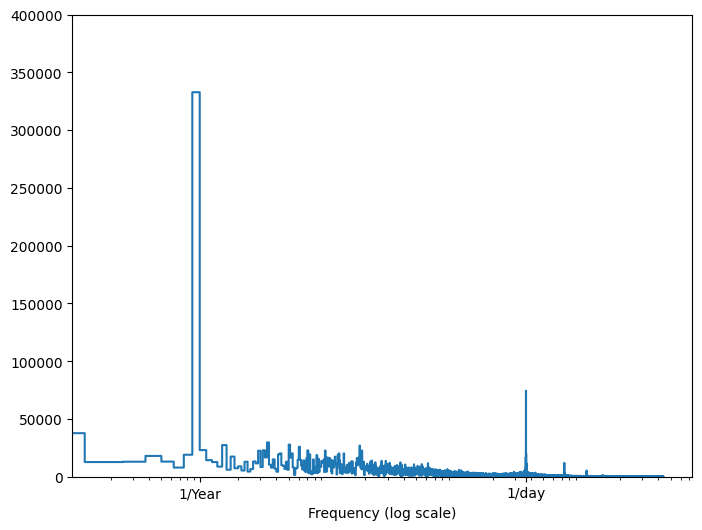

In [16]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 拆分数据

您将使用 `(70%, 20%, 10%)` 拆分出训练集、验证集和测试集。请注意，在拆分前数据**没有**随机打乱顺序。这有两个原因：

1. 确保仍然可以将数据切入连续样本的窗口。
2. 确保训练后在收集的数据上对模型进行评估，验证/测试结果更加真实。

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 归一化数据

在训练神经网络之前缩放特征很重要。归一化是进行此类缩放的常见方式：减去平均值，然后除以每个特征的标准偏差。

平均值和标准偏差应仅使用训练数据进行计算，从而使模型无法访问验证集和测试集中的值。

有待商榷的是：模型在训练时不应访问训练集中的未来值，以及应该使用移动平均数来进行此类规范化。这不是本教程的重点，验证集和测试集会确保我们获得（某种程度上）可靠的指标。因此，为了简单起见，本教程使用的是简单平均数。

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

现在看一下这些特征的分布。部分特征的尾部确实很长，但没有类似 `-9999` 风速值的明显错误。

<ipython-input-19-4ec9be458a7e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


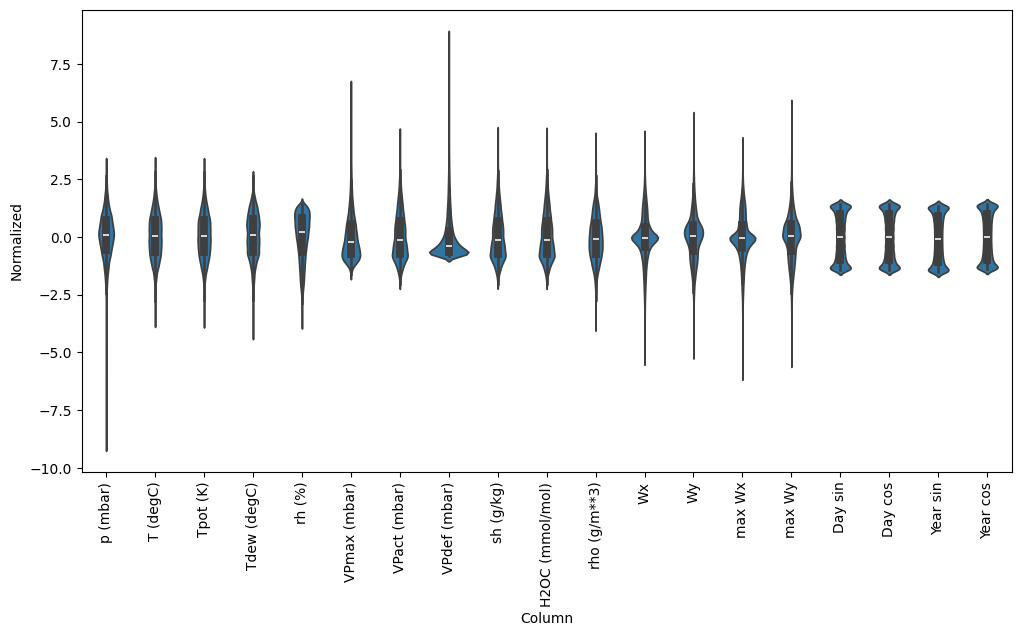

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口化

本教程中的模型将基于来自数据连续样本的窗口进行一组预测。

输入窗口的主要特征包括：

- 输入和标签窗口的宽度（时间步骤数量）。
- 它们之间的时间偏移量。
- 用作输入、标签或两者的特征。

本教程构建了各种模型（包括线性、DNN、CNN 和 RNN 模型），并将它们用于以下两种情况：

- *单输出*和*多输出*预测。
- *单时间步骤*和*多时间步骤*预测。

本部分重点介绍实现数据窗口化，以便将其重用到上述所有模型。


根据任务和模型类型，您可能需要生成各种数据窗口。下面是一些示例：

1. 例如，要在给定 24 小时历史记录的情况下对未来 24 小时作出一次预测，可以定义如下窗口：

![对未来 24 小时的一次预测。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/raw_window_24h.png?raw=1)

1. 给定 6 小时的历史记录，对未来 1 小时作出一次预测的模型将需要类似下面的窗口：

![对未来 1 小时的一次预测。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/raw_window_1h.png?raw=1)

本部分的剩余内容会定义 `WindowGenerator` 类。此类可以：

1. 处理如上图所示的索引和偏移量。
2. 将特征窗口拆分为 `(features, labels)` 对。
3. 绘制结果窗口的内容。
4. 使用 `tf.data.Dataset` 从训练、评估和测试数据高效生成这些窗口的批次。

### 1. 索引和偏移量

首先创建 `WindowGenerator` 类。`__init__` 方法包含输入和标签索引的所有必要逻辑。

它还将训练、评估和测试 DataFrame 作为输出。这些稍后将被转换为窗口的 `tf.data.Dataset`。

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

下面是创建本部分开头图表中所示的两个窗口的代码：

In [21]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 拆分

给定一个连续输入的列表，`split_window` 方法会将它们转换为输入窗口和标签窗口。

您之前定义的示例 `w2` 将按以下方式拆分：

![初始窗口都是连续的样本，这会将其拆分成一个（输入，标签）对](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/split_window.png?raw=1)

此图不显示数据的 `features` 轴，但此 `split_window` 函数还会处理 `label_columns`，因此可以将其用于单输出和多输出样本。

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

试试以下代码：

In [24]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [39]:
example_inputs

<tf.Tensor: shape=(32, 6, 19), dtype=float32, numpy=
array([[[ 0.87420154, -0.14999585, -0.21719345, ..., -0.59754425,
          0.32992774,  1.3706343 ],
        [ 0.8681756 , -0.37298962, -0.43840334, ..., -0.24546258,
          0.33090857,  1.3703479 ],
        [ 0.89589494, -0.5520779 , -0.6183513 , ...,  0.12335392,
          0.3318892 ,  1.3700607 ],
        [ 0.8922794 , -0.70112556, -0.7650604 , ...,  0.48377106,
          0.33286962,  1.3697728 ],
        [ 0.8850482 , -0.7461865 , -0.810907  , ...,  0.81122696,
          0.33384985,  1.3694843 ],
        [ 0.88384306, -0.7219229 , -0.7868376 , ...,  1.0834061 ,
          0.33482984,  1.3691951 ]],

       [[-0.73351824, -0.2955773 , -0.23782443, ...,  0.24566741,
         -1.4941956 ,  0.17602722],
        [-0.7106197 , -0.38454372, -0.3283715 , ..., -0.12314909,
         -1.4940838 ,  0.17702875],
        [-0.63107735, -0.47004393, -0.41891852, ..., -0.48356622,
         -1.4939711 ,  0.1780302 ],
        [-0.5635869 , -0.44

通常，TensorFlow 中的数据会被打包到数组中，其中最外层索引是交叉样本（“批次”维度）。中间索引是“时间”和“空间”（宽度、高度）维度。最内层索引是特征。

上面的代码使用了三个 7 时间步骤窗口的批次，每个时间步骤有 19 个特征。它将其拆分成一个 6 时间步骤的批次、19 个特征输入和一个 1 时间步骤 1 特征的标签。该标签仅有一个特征，因为 `WindowGenerator` 已使用 `label_columns=['T (degC)']` 进行了初始化。最初，本教程将构建预测单个输出标签的模型。

### 3. 绘图

下面是一个绘图方法，可以对拆分窗口进行简单可视化：

In [25]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

此绘图根据项目引用的时间来对齐输入、标签和（稍后的）预测：

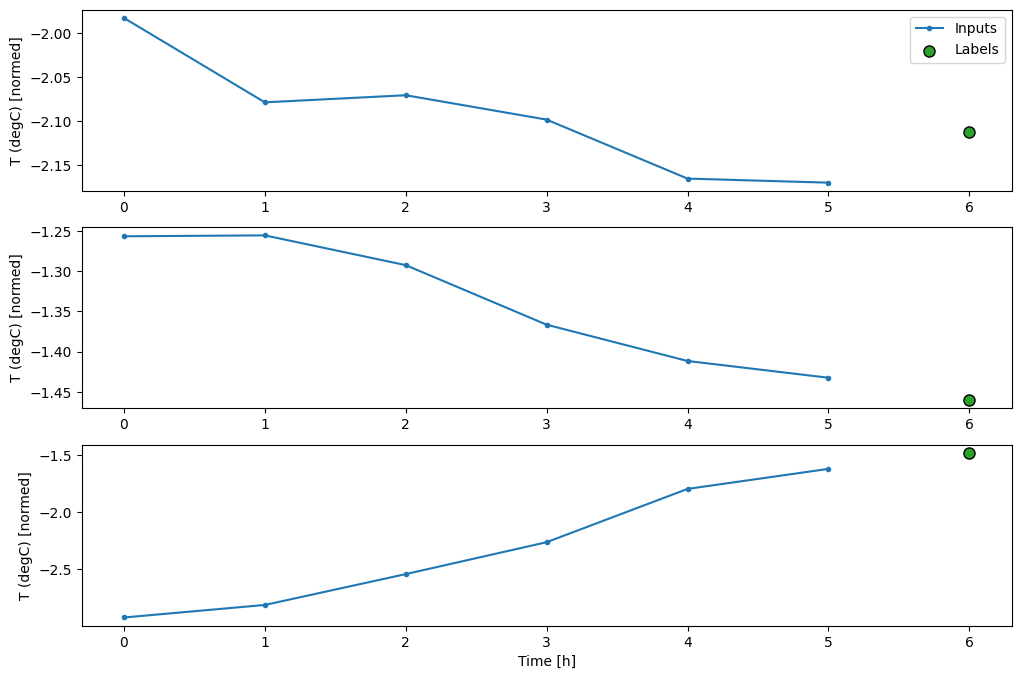

In [27]:
w2.plot()

您可以绘制其他列，但是样本窗口 `w2` 配置仅包含 `T (degC)` 列的标签。

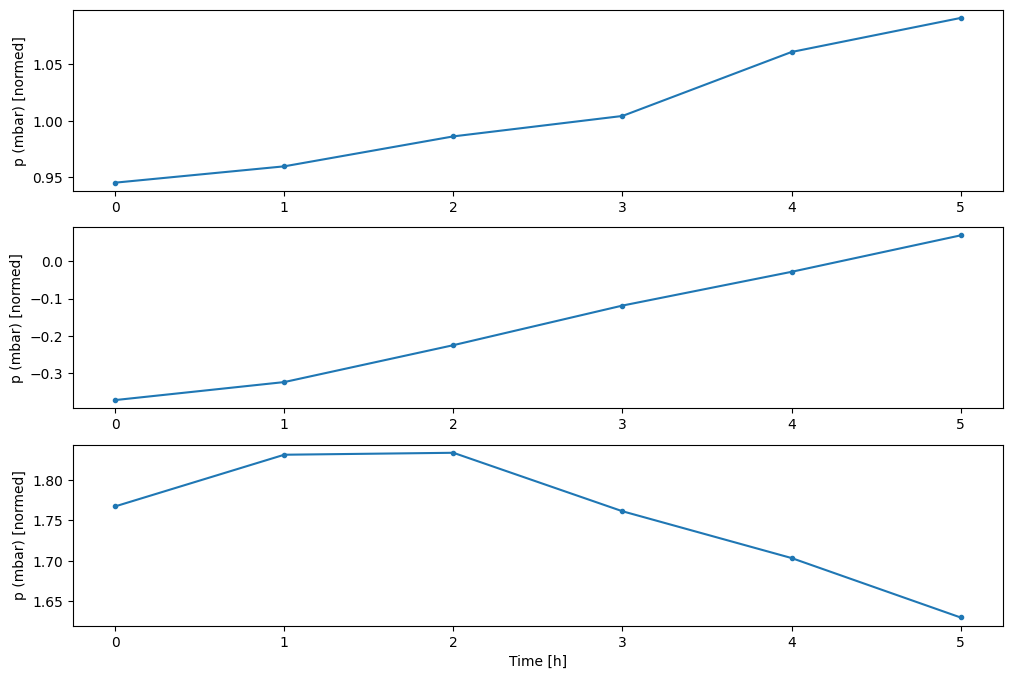

In [28]:
w2.plot(plot_col='p (mbar)')

### 4. 创建 `tf.data.Dataset`

最后，此 `make_dataset` 方法将获取时间序列 DataFrame 并使用 `tf.keras.utils.timeseries_dataset_from_array` 函数将其转换为 `(input_window, label_window)` 对的 `tf.data.Dataset`。

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 对象包含训练、验证和测试数据。

使用您之前定义的 `make_dataset` 方法添加属性以作为 `tf.data.Dataset` 访问它们。此外，添加一个标准样本批次以便于访问和绘图：

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

现在，`WindowGenerator` 对象允许您访问 `tf.data.Dataset` 对象，因此您可以轻松迭代数据。

`Dataset.element_spec` 属性会告诉您数据集元素的结构、数据类型和形状。

In [31]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

在 `Dataset` 上进行迭代会产生具体批次：

In [32]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## 单步模型

基于此类数据能够构建的最简单模型，能够仅根据当前条件预测单个特征的值，即未来的一个时间步骤（1 小时）。

因此，从构建模型开始，预测未来 1 小时的 `T (degC)` 值。

![预测下一个时间步骤](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/narrow_window.png?raw=1)

配置 `WindowGenerator` 对象以生成下列单步 `(input, label)` 对：

In [40]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` 会根据训练、验证和测试集创建 `tf.data.Datasets`，使您可以轻松迭代数据批次。


In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 基线

在构建可训练模型之前，最好将性能基线作为与以后更复杂的模型进行比较的点。

第一个任务是在给定所有特征的当前值的情况下，预测未来 1 小时的温度。当前值包括当前温度。

因此，从仅返回当前温度作为预测值的模型开始，预测“无变化”。这是一个合理的基线，因为温度变化缓慢。当然，如果您对更远的未来进行预测，此基线的效果就不那么好了。

![将输入发送到输出](https://github.com/tensorflow/docs-l10n/blob/master/site/en-snapshot/tutorials/structured_data/images/baseline.png?raw=true)

In [41]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

实例化并评估此模型：

In [42]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0788


上面的代码打印了一些性能指标，但这些指标并没有使您对模型的运行情况有所了解。

`WindowGenerator` 有一种绘制方法，但只有一个样本，绘图不是很有趣。

因此，创建一个更宽的 `WindowGenerator` 来一次生成包含 24 小时连续输入和标签的窗口。新的 `wide_window` 变量不会更改模型的运算方式。模型仍会根据单个输入时间步骤对未来 1 小时进行预测。这里 `time` 轴的作用类似于 `batch` 轴：每个预测都是独立进行的，时间步骤之间没有交互：

In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [36]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 1)


此扩展窗口可以直接传递到相同的 `baseline` 模型，而无需修改任何代码。能做到这一点是因为输入和标签具有相同数量的时间步骤，并且基线只是将输入转发至输出：

![对未来 1 小时进行一次预测，每小时一次。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/last_window.png?raw=1)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


通过绘制基线模型的预测值，可以注意到只是标签向右移动了 1 小时：

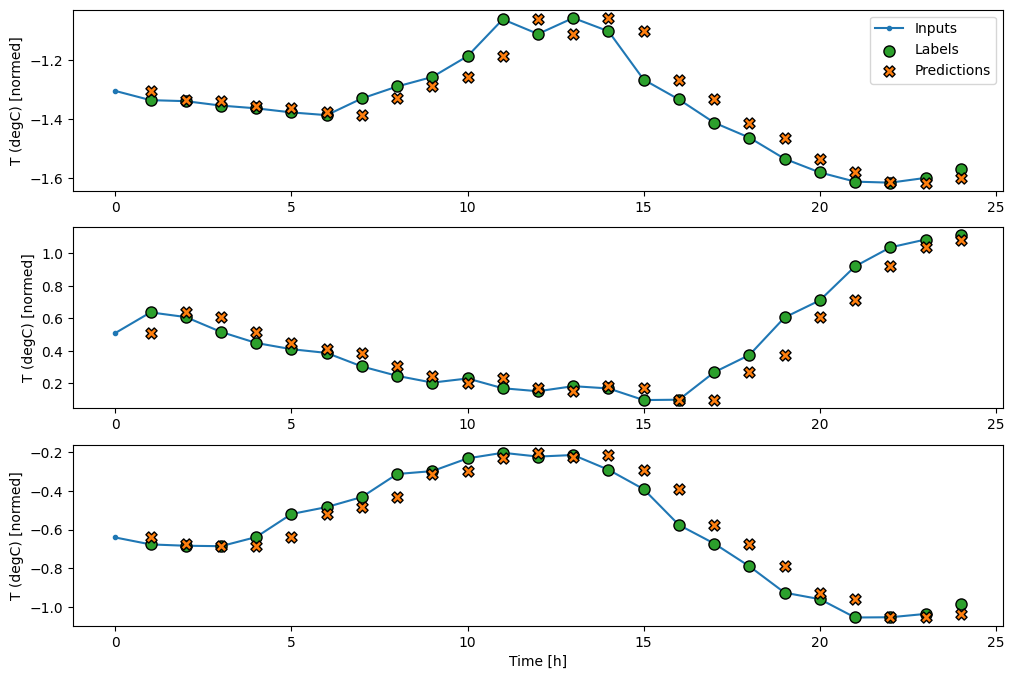

In [38]:
wide_window.plot(baseline)

在上面三个样本的绘图中，单步模型运行了 24 个小时。这需要一些解释：

- 蓝色的 `Inputs` 行显示每个时间步骤的输入温度。模型会接收所有特征，而该绘图仅显示温度。
- 绿色的 `Labels` 点显示目标预测值。这些点在预测时间，而不是输入时间显示。这就是为什么标签范围相对于输入移动了 1 步。
- 橙色的 `Predictions` 叉是模型针对每个输出时间步骤的预测。如果模型能够进行完美预测，则预测值将直接落在 `Labels` 上。

### 线性模型

可以应用于此任务的最简单的**可训练**模型是在输入和输出之间插入线性转换。在这种情况下，时间步骤的输出仅取决于该步骤：

![单步预测](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/narrow_window.png?raw=1)

没有设置 `activation` 的 `tf.keras.layers.Dense` 层是线性模型。层仅会将数据的最后一个轴从 `(batch, time, inputs)` 转换为 `(batch, time, units)`；它会单独应用于 `batch` 和 `time` 轴的每个条目。

In [44]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [45]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


本教程训练许多模型，因此将训练过程打包到一个函数中：

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

训练模型并评估其性能：

In [47]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6455 - mean_absolute_error: 0.5529 - val_loss: 0.0189 - val_mean_absolute_error: 0.1044
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0153 - mean_absolute_error: 0.0917 - val_loss: 0.0096 - val_mean_absolute_error: 0.0725
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0097 - mean_absolute_error: 0.0724 - val_loss: 0.0090 - val_mean_absolute_error: 0.0698
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0706 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0685
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0091 - mean_absolute_

与 `baseline` 模型类似，可以在宽度窗口的批次上调用线性模型。使用这种方式，模型会在连续的时间步骤上进行一系列独立预测。`time` 轴的作用类似于另一个 `batch` 轴。在每个时间步骤上，预测之间没有交互。

![单步预测](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/wide_window.png?raw=1)

In [48]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


下面是 `wide_widow` 上它的样本预测绘图。请注意，在许多情况下，预测值显然比仅返回输入温度更好，但在某些情况下则会更差：

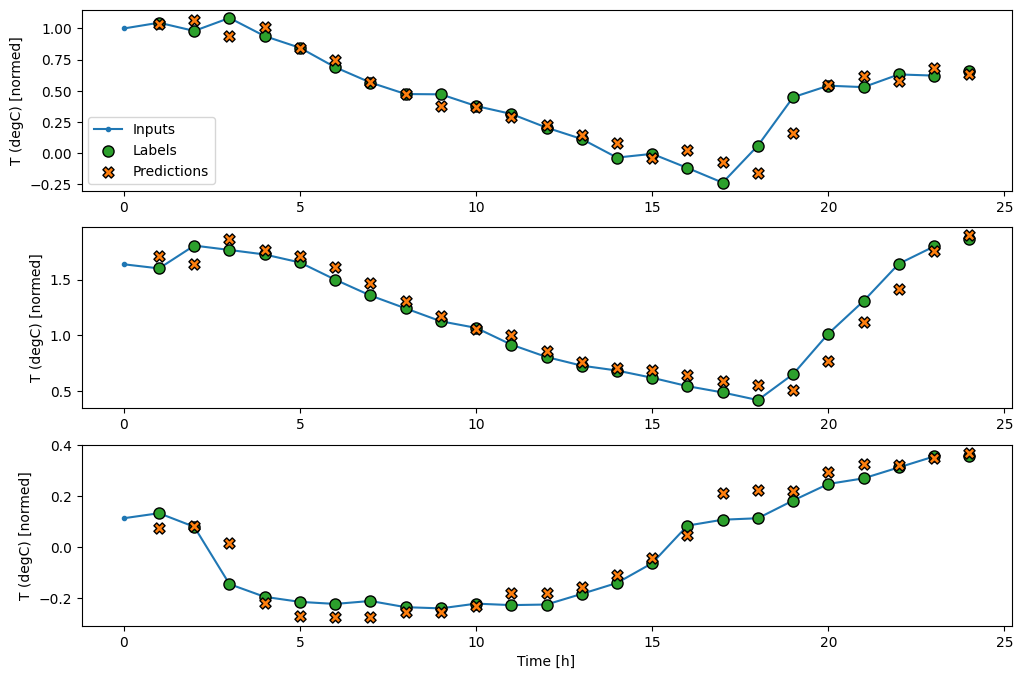

In [49]:
wide_window.plot(linear)

线性模型的优点之一是它们相对易于解释。您可以拉取层的权重，并呈现分配给每个输入的权重：

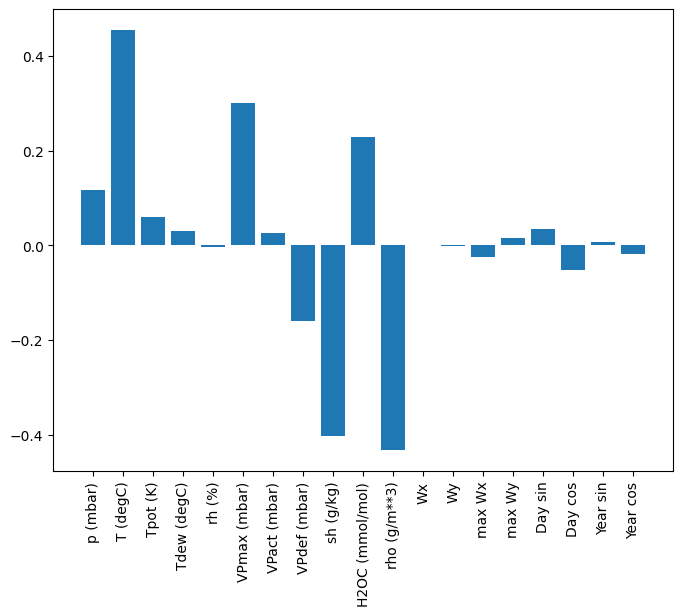

In [50]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

有时模型甚至不会将大多数权重放在输入 `T (degC)` 上。这是随机初始化的风险之一。

### 密集

在应用实际运算多个时间步骤的模型之前，值得研究一下更深、更强大的单输入步骤模型的性能。

下面是一个与 `linear` 模型类似的模型，只不过它在输入和输出之间堆叠了几个 `Dense` 层：

In [51]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0316 - mean_absolute_error: 0.1030 - val_loss: 0.0083 - val_mean_absolute_error: 0.0672
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0080 - mean_absolute_error: 0.0644 - val_loss: 0.0081 - val_mean_absolute_error: 0.0655
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0076 - mean_absolute_error: 0.0623 - val_loss: 0.0071 - val_mean_absolute_error: 0.0605
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0073 - mean_absolute_error: 0.0612 - val_loss: 0.0081 - val_mean_absolute_error: 0.0662
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0604 - val_loss: 0.0067 - val_mean_absolute_error: 0.0580
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0598 - val_loss: 0.0068 - val_mean_absolute_error: 0.0577
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0070 - mean_absolute_

### 多步密集

单时间步骤模型没有其输入的当前值的上下文。它看不到输入特征随时间变化的情况。要解决此问题，模型在进行预测时需要访问多个时间步骤：

![每次预测都使用三个时间步骤。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/conv_window.png?raw=1)


`baseline`、`linear` 和 `dense` 模型会单独处理每个时间步骤。在这里，模型将接受多个时间步骤作为输入，以生成单个输出。

创建一个 `WindowGenerator`，它将生成 3 小时输入和 1 小时标签的批次：

请注意，`Window` 的 `shift` 参数与两个窗口的末尾相关。


In [52]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

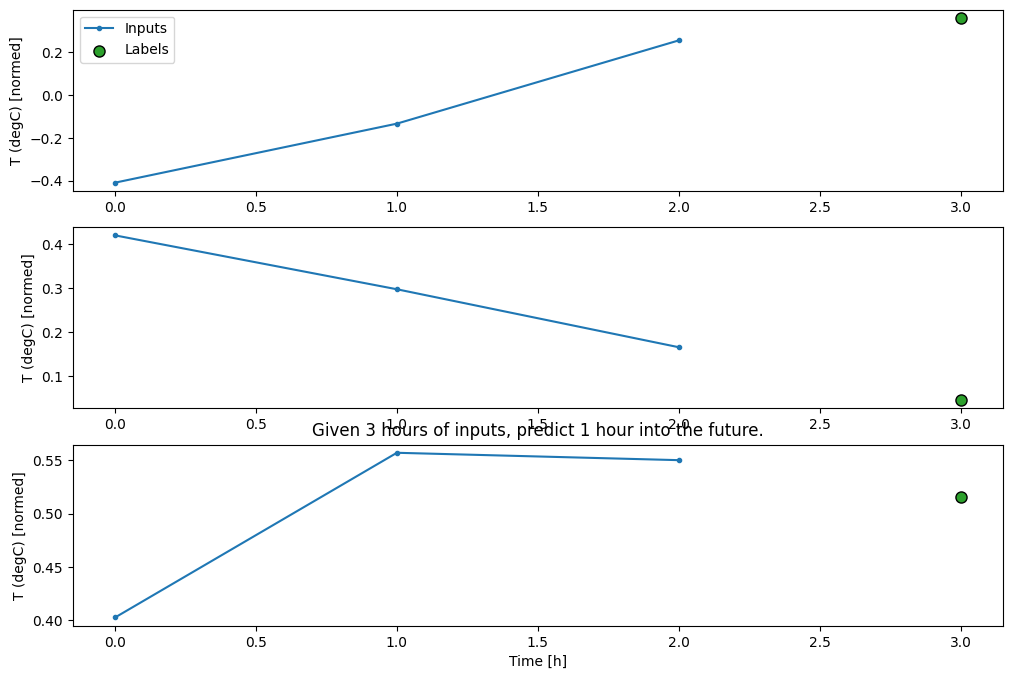

In [61]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

您可以通过添加 `tf.keras.layers.Flatten` 作为模型的第一层，在多输入步骤窗口上训练 `dense` 模型：

In [62]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [63]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [64]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mean_absolute_error: 0.0545


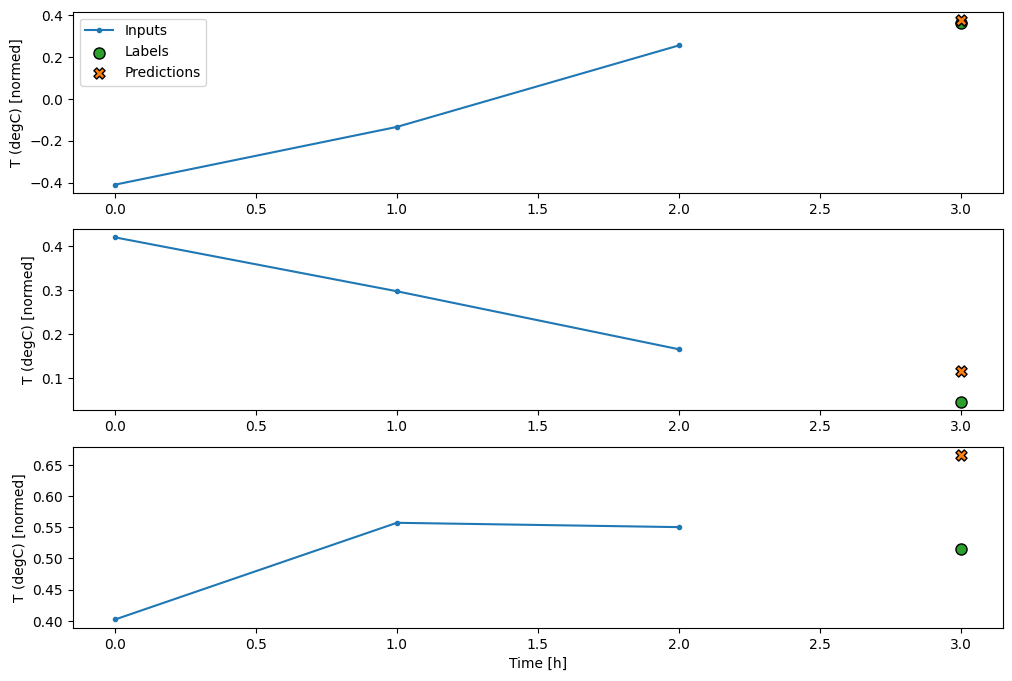

In [59]:
conv_window.plot(multi_step_dense)

此方法的主要缺点是，生成的模型只能在具有此形状的输入窗口上执行。

In [65]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


下一部分中的卷积模型将解决这个问题。

### 卷积神经网络

卷积层 (`tf.keras.layers.Conv1D`) 也需要多个时间步骤作为每个预测的输入。

下面的模型与 `multi_step_dense` **相同**，使用卷积进行了重写。

请注意以下变化：

- `tf.keras.layers.Flatten` 和第一个 `tf.keras.layers.Dense` 替换成了 `tf.keras.layers.Conv1D`。
- 由于卷积将时间轴保留在其输出中，不再需要 `tf.keras.layers.Reshape`。

In [66]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

在一个样本批次上运行上述模型，以查看模型是否生成了具有预期形状的输出：

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


在 `conv_window` 上训练和评估上述模型，它应该提供与 `multi_step_dense` 模型类似的性能。

In [67]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0547


此 `conv_model` 和 `multi_step_dense` 模型的区别在于，`conv_model` 可以在任意长度的输入上运行。卷积层应用于输入的滑动窗口：

![在序列上执行卷积模型](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/wide_conv_window.png?raw=1)

如果在较宽的输入上运行此模型，它将生成较宽的输出：

In [68]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


请注意，输出比输入短。要进行训练或绘图，需要标签和预测具有相同长度。因此，构建 `WindowGenerator` 以使用一些额外输入时间步骤生成宽窗口，从而使标签和预测长度匹配：

In [69]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [72]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


现在，您可以在更宽的窗口上绘制模型的预测。请注意第一个预测之前的 3 个输入时间步骤。这里的每个预测都基于之前的 3 个时间步骤：

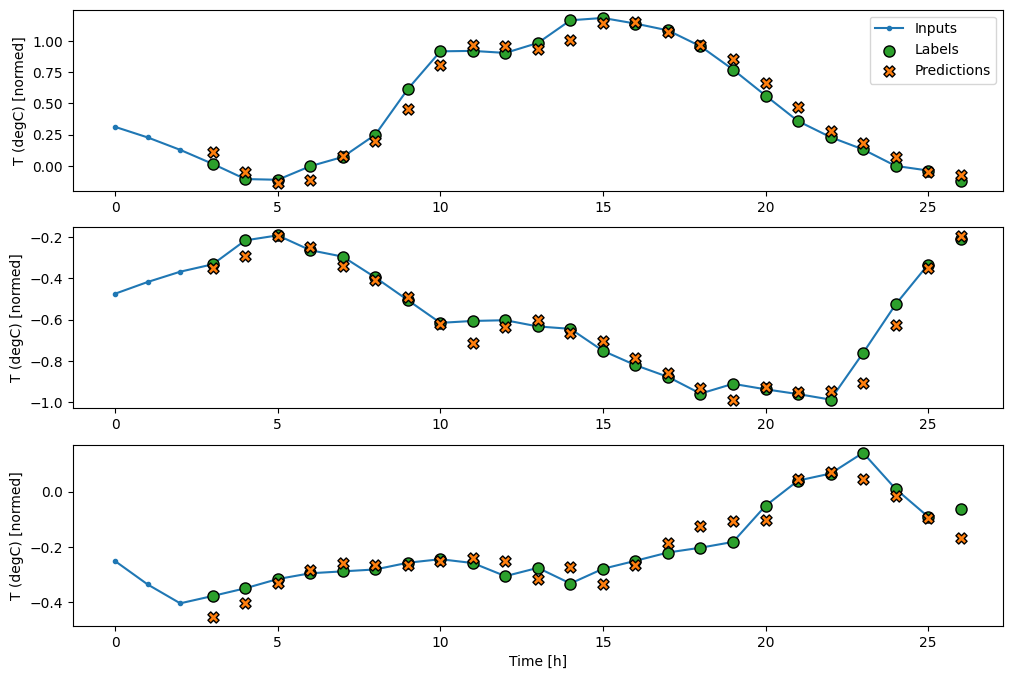

In [70]:
wide_conv_window.plot(conv_model)

### 循环神经网络

循环神经网络 (RNN) 是一种非常适合时间序列数据的神经网络。RNN 分步处理时间序列，从时间步骤到时间步骤地维护内部状态。

您可以在[使用 RNN 的文本生成](https://tensorflow.google.cn/text/tutorials/text_generation)教程和[使用 Keras 的递归神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn) 指南中了解详情。

在本教程中，您将使用称为“长短期记忆网络”(`tf.keras.layers.LSTM`) 的 RNN 层。

对所有 Keras RNN 层（例如 `tf.keras.layers.LSTM`）都很重要的一个构造函数参数是 `return_sequences`。此设置可以通过以下两种方式配置层：

1. 如果为 `False`（默认值），则层仅返回最终时间步骤的输出，使模型有时间在进行单个预测前对其内部状态进行预热：

![lstm 预热并进行单一预测](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/lstm_1_window.png?raw=true)

1. 如果为 `True`，层将为每个输入返回一个输出。这对以下情况十分有用：
    - 堆叠 RNN 层。
    - 同时在多个时间步骤上训练模型。

![lstm在每个时间步后进行预测](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [73]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True` 时，模型一次可以在 24 小时的数据上进行训练。

注：这将对模型的性能给出悲观看法。在第一个时间步骤中，模型无法访问之前的步骤，因此无法比之前展示的简单 `linear` 和 `dense` 模型表现得更好。

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0511


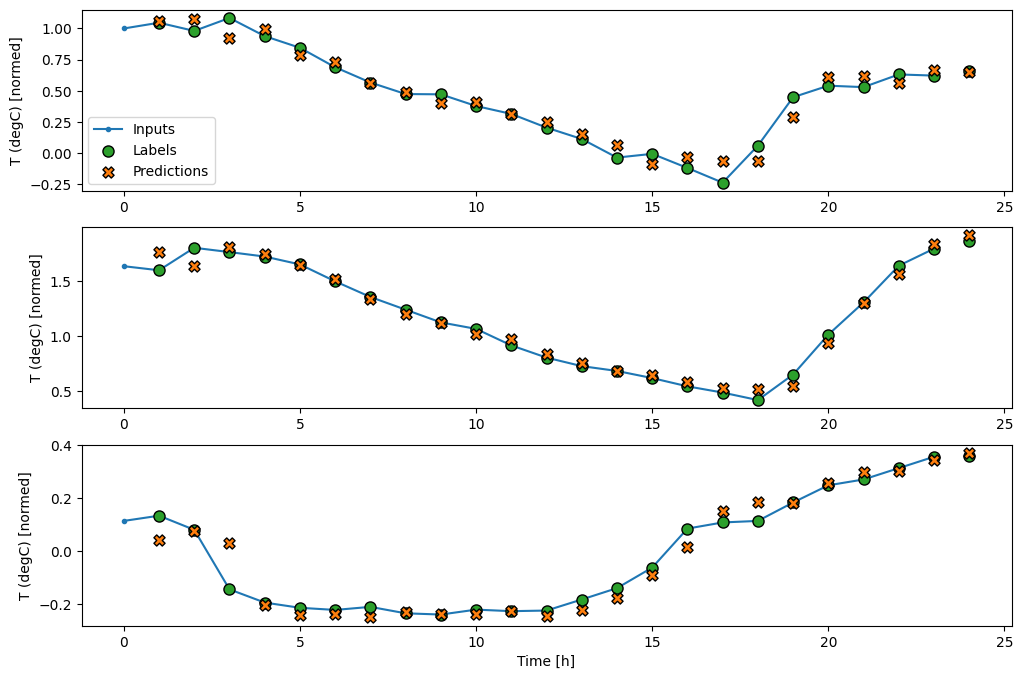

In [76]:
wide_window.plot(lstm_model)

### 性能

使用此数据集时，通常每个模型的性能都比之前的模型稍好一些：

In [83]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

ValueError: 'mean_absolute_error' is not in list

In [80]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0671
Dense       : 0.0576
Multi step dense: 0.0543
Conv        : 0.0550
LSTM        : 0.0522


### 多输出模型

到目前为止，所有模型都为单个时间步骤预测了单个输出特征，`T (degC)`。

只需更改输出层中的单元数并调整训练窗口，以将所有特征包括在 `labels` (`example_labels`) 中，就可以将所有上述模型转换为预测多个特征：

In [82]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


请注意，上面标签的 `features` 轴现在具有与输入相同的深度，而不是 1。

#### 基线

此处可以使用相同的基线模型 (`Baseline`)，但这次重复所有特征，而不是选择特定的 `label_index`：

In [77]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [84]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0890 - mean_absolute_error: 0.1595


#### 密集

In [85]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [87]:
num_features

19

In [86]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0683 - mean_absolute_error: 0.1310


#### RNN


In [88]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0620 - mean_absolute_error: 0.1203

CPU times: user 8min 54s, sys: 35.5 s, total: 9min 30s
Wall time: 8min 38s


<a id="residual"></a>

#### 高级：残差连接

先前的 `Baseline` 模型利用了以下事实：序列在时间步骤之间不会剧烈变化。到目前为止，本教程中训练的每个模型都进行了随机初始化，然后必须学习输出相较上一个时间步骤改变较小这一知识。

尽管您可以通过仔细初始化来解决此问题，但将此问题构建到模型结构中则更加简单。

在时间序列分析中构建的模型，通常会预测下一个时间步骤中的值会如何变化，而非直接预测下一个值。类似地，深度学习中的<a href="https://arxiv.org/abs/1512.03385" class="external">残差网络</a>（或 ResNet）指的是，每一层都会添加到模型的累计结果中的架构。

这就是利用“改变应该较小”这一知识的方式。

![带有残差连接的模型](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/residual.png?raw=1)

本质上，这将初始化模型以匹配 `Baseline`。对于此任务，它可以帮助模型更快收敛，且性能稍好。

该方法可以与本教程中讨论的任何模型结合使用。

这里将它应用于 LSTM 模型，请注意 `tf.initializers.zeros` 的使用，以确保初始的预测改变很小，并且不会压制残差连接。此处的梯度没有破坏对称性的问题，因为 `zeros` 仅用于最后一层。

In [89]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [90]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0626 - mean_absolute_error: 0.1185

CPU times: user 3min 53s, sys: 15.7 s, total: 4min 9s
Wall time: 3min 24s


#### 性能

In [100]:
performance.items


<function dict.items>

以下是这些多输出模型的整体性能。

In [1]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

NameError: name 'np' is not defined

In [92]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1320
LSTM           : 0.1208
Residual LSTM  : 0.1193


以上性能是所有模型输出的平均值。

## 多步模型

前几个部分中的单输出和多输出模型都对未来 1 小时进行**单个时间步骤预测**。

本部分介绍如何扩展这些模型以进行**多时间步骤预测**。

在多步预测中，模型需要学习预测一系列未来值。因此，与单步模型（仅预测单个未来点）不同，多步模型预测未来值的序列。

大致有两种预测方法：

1. 单次预测，一次预测整个时间序列。
2. 自回归预测，模型仅进行单步预测并将输出作为输入进行反馈。

在本部分中，所有模型都将预测**所有输出时间步骤中的所有特征**。


对于多步模型而言，训练数据仍由每小时样本组成。但是，在这里，模型将在给定过去 24 小时的情况下学习预测未来 24 小时。

下面是一个 `Window` 对象，该对象从数据集生成以下切片：

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

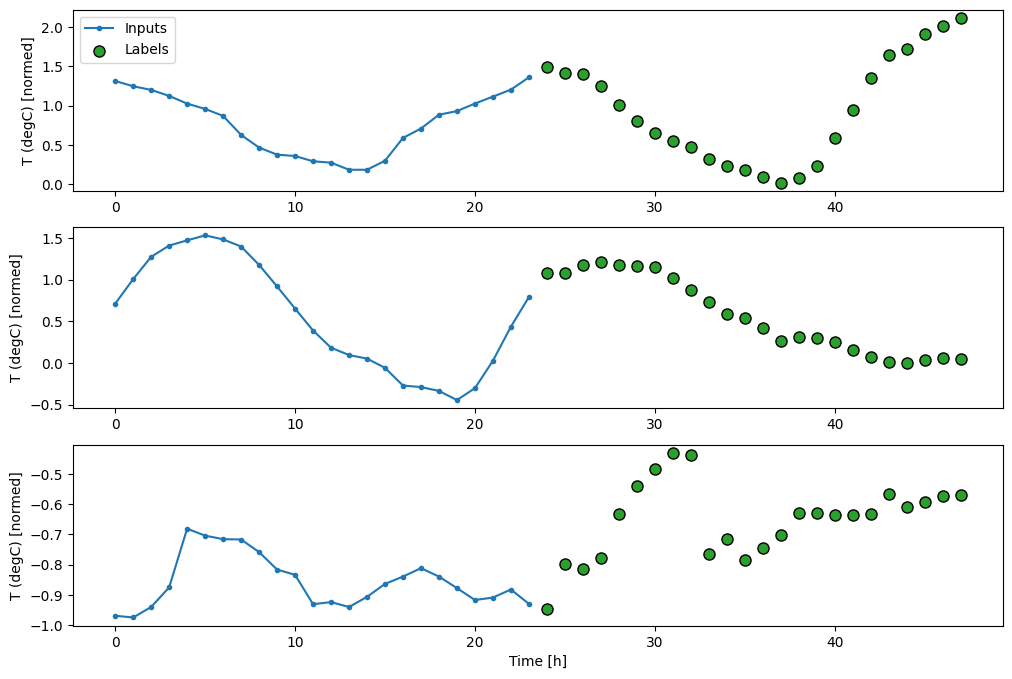

In [37]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 基线

此任务的一个简单基线是针对所需数量的输出时间步骤重复上一个输入时间步骤：

![对每个输出步骤重复最后一次输入](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_last.png?raw=1)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6227 - mean_absolute_error: 0.4980


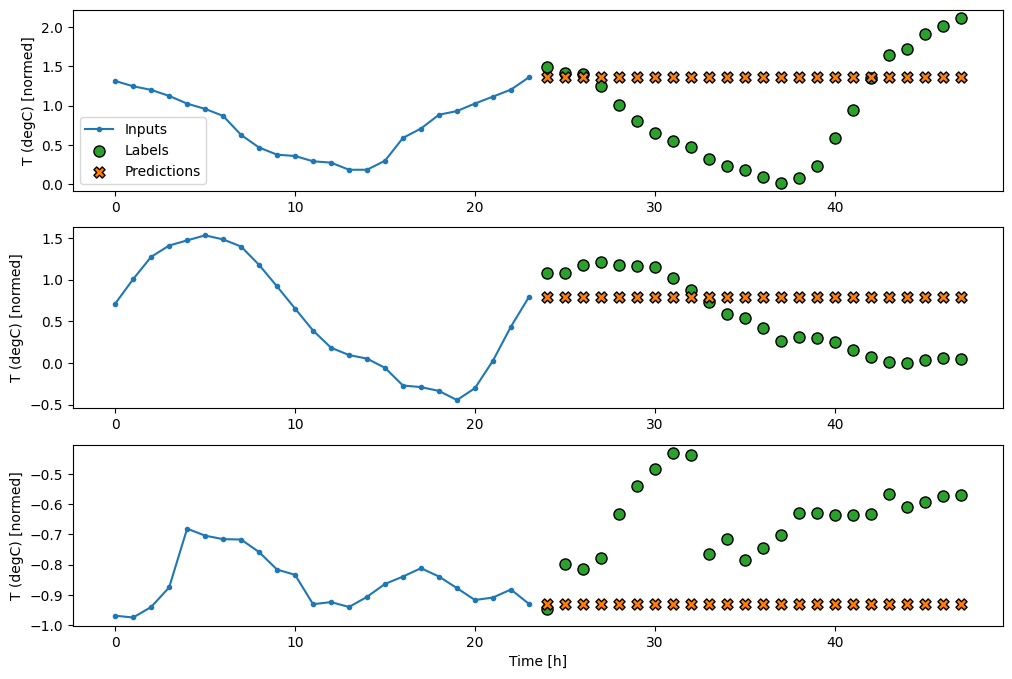

In [38]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

由于此任务是在给定过去 24 小时的情况下预测未来 24 小时，另一种简单的方式是重复前一天，假设明天是类似的：

![重复前一天](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_repeat.png?raw=1)

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4228 - mean_absolute_error: 0.3945


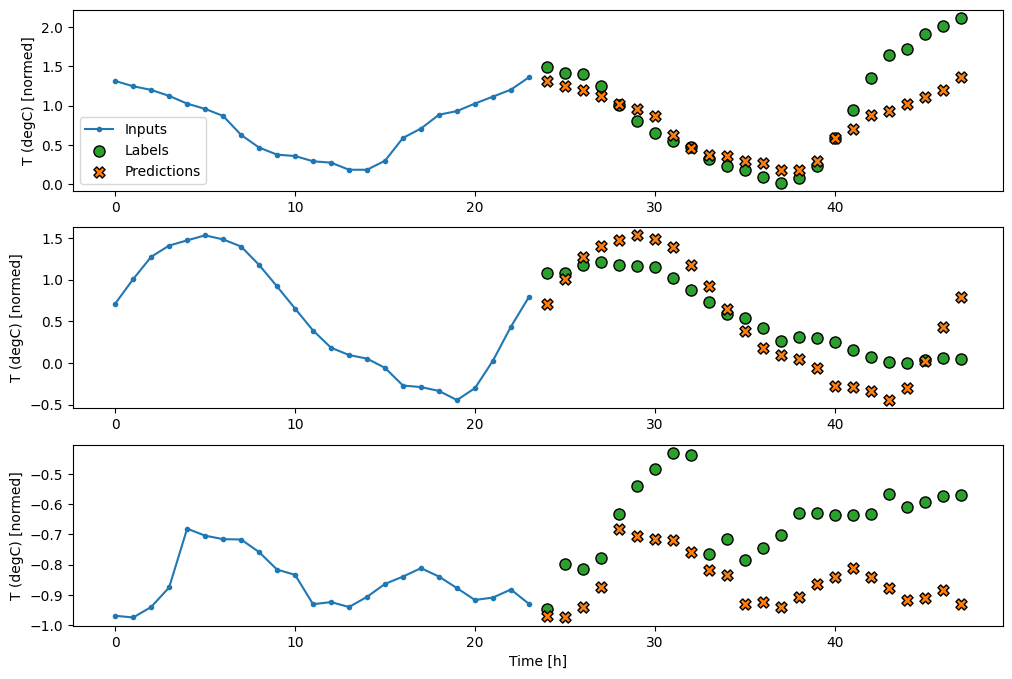

In [39]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### 单次模型

解决此问题的一种高级方法是使用“单次”模型，该模型可以在单个步骤中对整个序列进行预测。

这可以使用 `OUT_STEPS*features` 输出单元作为 `tf.keras.layers.Dense` 高效实现。模型只需要将输出调整为所需的 `(OUTPUT_STEPS, features)`。

#### 线性

基于最后输入时间步骤的简单线性模型优于任何基线，但能力不足。该模型需要根据线性投影的单个输入时间步骤来预测 `OUTPUT_STEPS` 个时间步骤。它只能捕获行为的低维度切片，可能主要基于一天中的时间和一年中的时间。

![从上一个时间步骤预测所有时间步骤](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_dense.png?raw=1)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2571 - mean_absolute_error: 0.3054


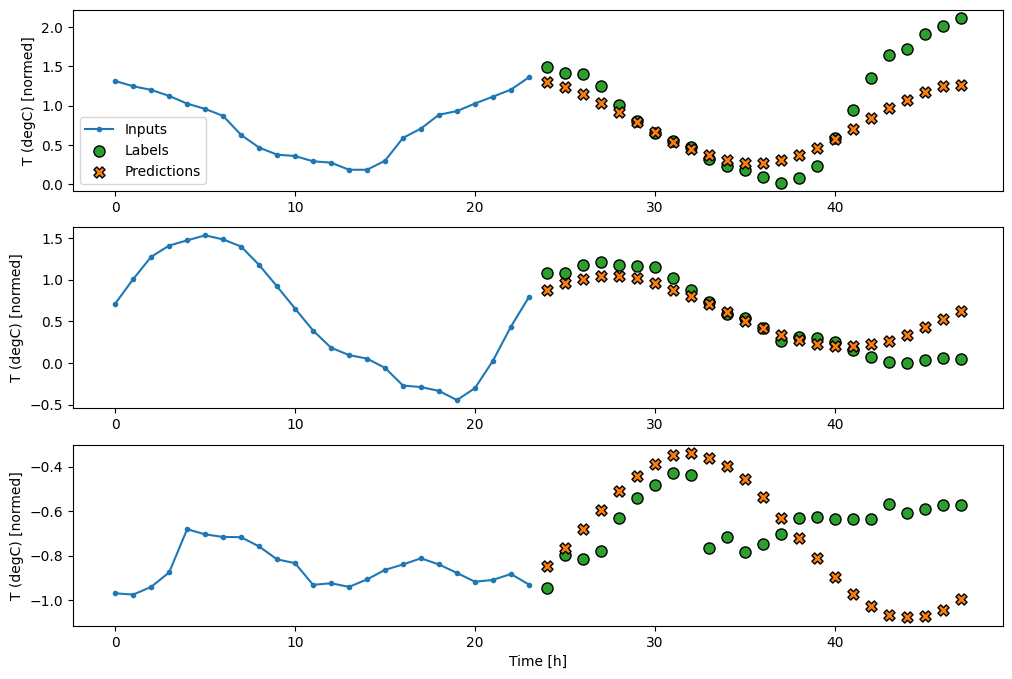

In [42]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### 密集

在输入和输出之间添加 `tf.keras.layers.Dense` 可为线性模型提供更大能力，但仍仅基于单个输入时间步骤。

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2185 - mean_absolute_error: 0.2810


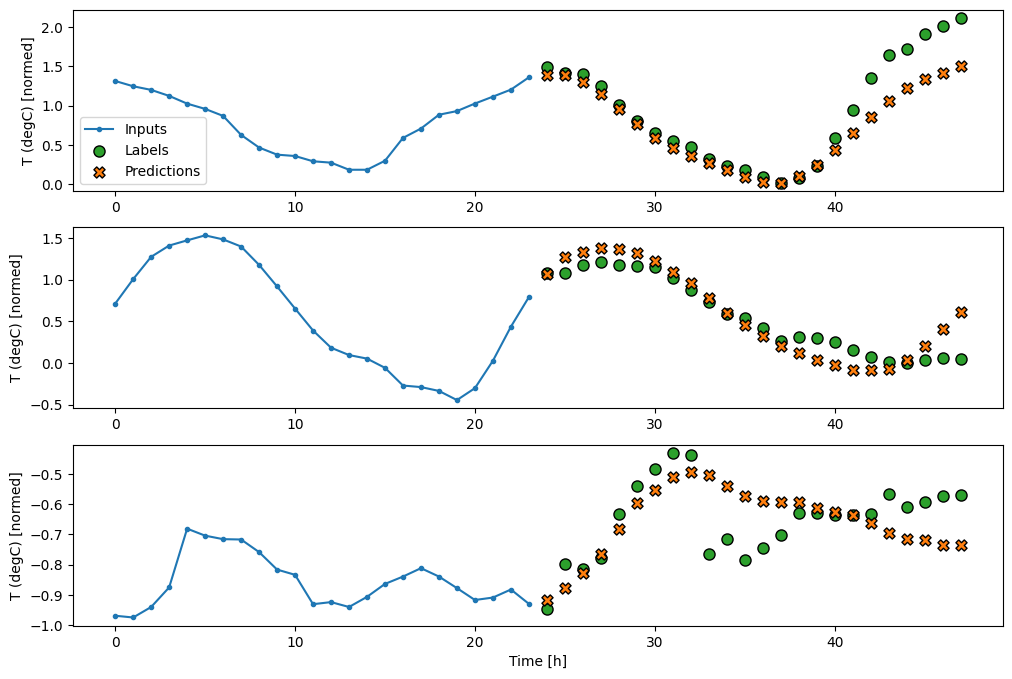

In [43]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

卷积模型基于固定宽度的历史记录进行预测，可能比密集模型的性能更好，因为它可以看到随时间变化的情况：

![卷积模型查看事物如何随时间变化。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_conv.png?raw=1)

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2170 - mean_absolute_error: 0.2829


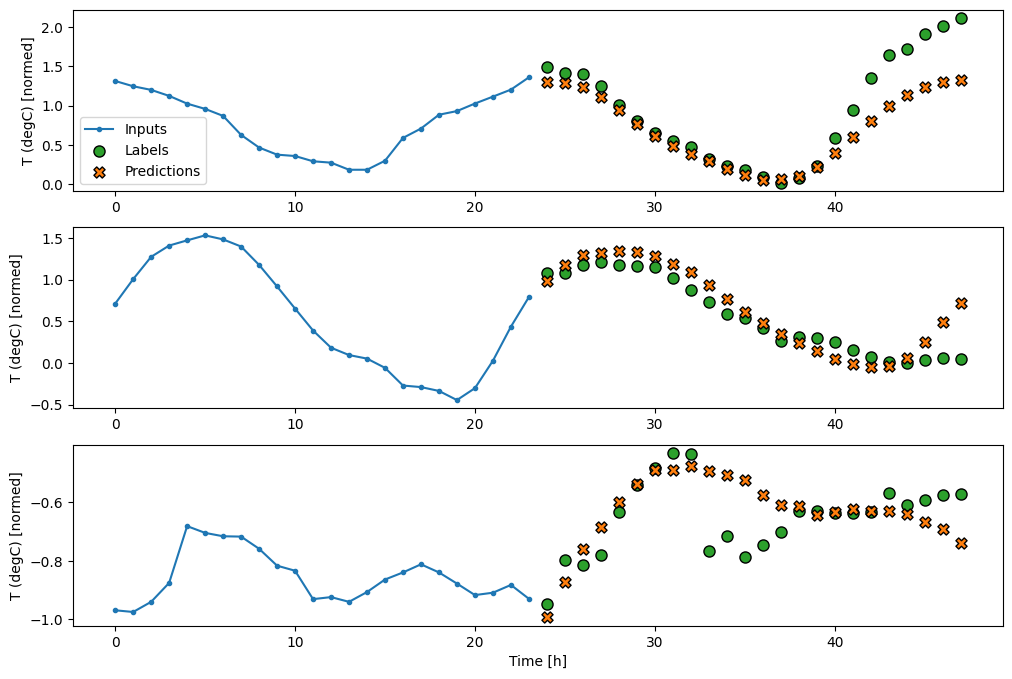

In [44]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

如果循环模型与模型所做的预测相关，则可以学习使用较长的输入历史记录。在这里，模型将积累 24 小时的内部状态，然后对接下来的 24 小时进行单次预测。

在此单次格式中，LSTM 只需要在最后一个时间步骤上生成输出，因此在 `tf.keras.layers.LSTM` 中设置 `return_sequences=False`。

![lstm 积累输入窗口的状态，并对未来 24 小时进行一次预测。](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_lstm.png?raw=1)


437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2158 - mean_absolute_error: 0.2882


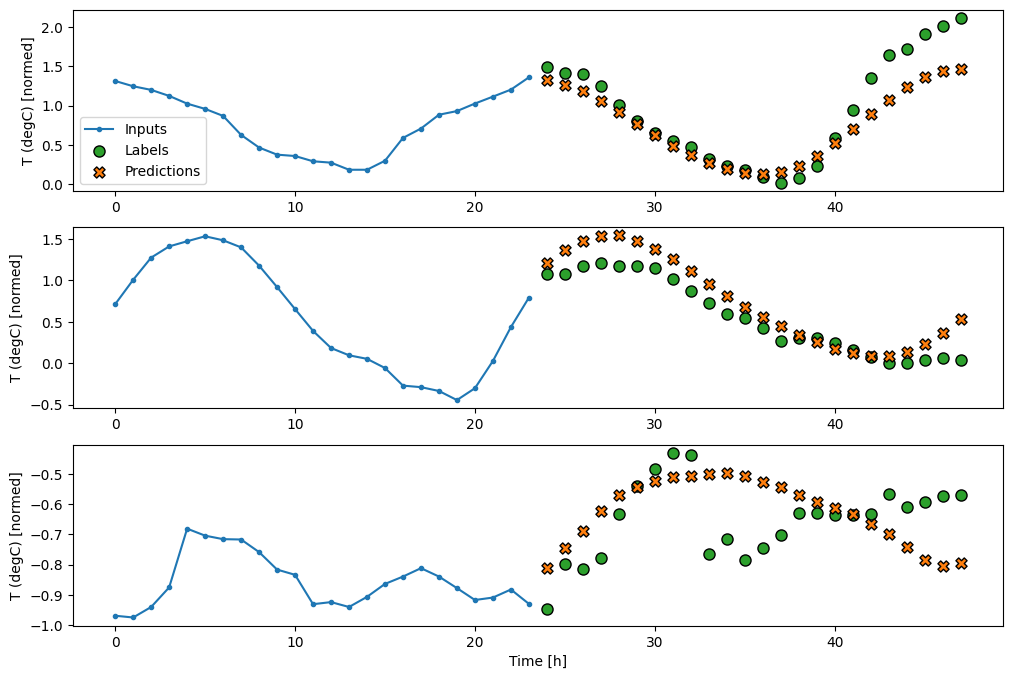

In [45]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 高级：自回归模型

上述模型均在单个步骤中预测整个输出序列。

在某些情况下，模型将此预测分解为单个时间步骤可能比较有帮助。 然后，模型的每个输出都可以在每个步骤反馈给自己，并可以根据前一个输出进行预测，就像经典的<a href="https://arxiv.org/abs/1308.0850" class="external">使用循环神经网络生成序列</a>中介绍的一样。

此类模型的一个明显优势是可以将其设置为生成长度不同的输出。

您可以采用本教程前半部分中训练的任意一个单步多输出模型，并在自回归反馈循环中运行，但是在这里，您将重点关注经过显式训练的模型。

![将模型的输出反馈到其输入](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

本教程仅构建自回归 RNN 模型，但是该模式可以应用于设计为输出单个时间步骤的任何模型。

模型将具有与之前的单步 LSTM 模型相同的基本形式：一个 `tf.keras.layers.LSTM` ，后接一个将 `LSTM` 层输出转换为模型预测的 `tf.keras.layers.Dense` 层。

`tf.keras.layers.LSTM` 是封装在更高级 `tf.keras.layers.RNN` 中的 `tf.keras.layers.LSTMCell`，它为您管理状态和序列结果（有关详细信息，请参阅[使用 Keras 的循环神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn) 指南）。

在这种情况下，模型必须手动管理每个步骤的输入，因此它直接将 `tf.keras.layers.LSTMCell` 用于较低级别的单个时间步骤接口。

In [46]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [47]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

该模型需要的第一个方法是 `warmup`，用来根据输入初始化其内部状态。训练后，此状态将捕获输入历史记录的相关部分。这等效于先前的单步 `LSTM` 模型：

In [48]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

此方法返回单个时间步骤预测以及 `LSTM` 的内部状态：

In [49]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

有了 `RNN` 的状态和初始预测，您现在可以继续迭代模型，并在每一步将预测作为输入反馈给模型。

收集输出预测的最简单方式是使用 Python 列表，并在循环后使用 `tf.stack`。

注：像这样堆叠 Python 列表仅适用于 Eager-Execution，使用 `Model.compile(..., run_eagerly=True)` 进行训练，或使用固定长度的输出。对于动态输出长度，您需要使用 `tf.TensorArray` 代替 Python 列表，并用 `tf.range` 代替 Python `range`。

In [50]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

在示例输入上运行此模型：

In [51]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


现在，训练模型：

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2248 - mean_absolute_error: 0.2981


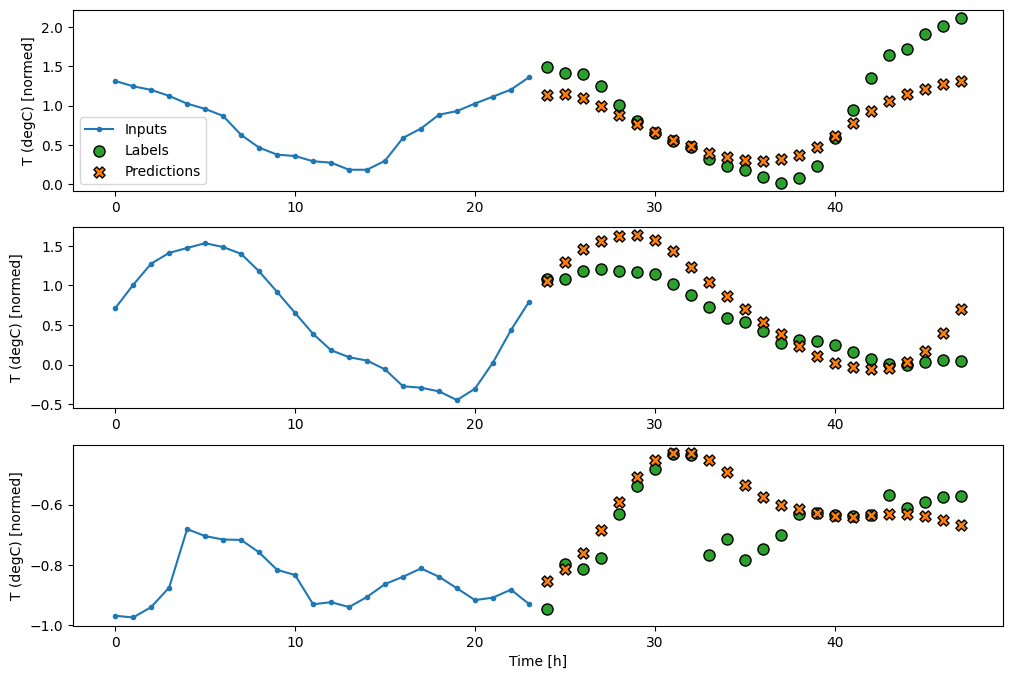

In [53]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 性能

在这个问题上，作为模型复杂性的函数，返回值在明显递减。

In [54]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

NameError: name 'lstm_model' is not defined

本教程前半部分的多输出模型的指标显示了所有输出特征的平均性能。这些性能类似，但在输出时间步骤上也进行了平均。

In [55]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2986
Dense   : 0.2767
Conv    : 0.2750
LSTM    : 0.2787
AR LSTM : 0.2919


从密集模型到卷积模型和循环模型，所获得的增益只有百分之几（如果有的话），而自回归模型的表现显然更差。因此，在**这个**问题上使用这些更复杂的方法可能并不值得，但如果不尝试就无从知晓，而且这些模型可能会对**您的**问题有所帮助。

## 后续步骤

本教程是使用 TensorFlow 进行时间序列预测的简单介绍。

要了解更多信息，请参阅：

- <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>（第 2 版）第 15 章。
- [Python 深度学习](https://www.manning.com/books/deep-learning-with-python)第 6 章。
- <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity 的 Intro to TensorFlow for deep learning</a> 第 8 课，包括<a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">练习笔记本</a>。

还要记住，您可以在 TensorFlow 中实现任何<a href="https://otexts.com/fpp2/index.html" class="external">经典时间序列模型</a>，本教程仅重点介绍了 TensorFlow 的内置功能。


# 新段落